In [1]:
import torch
import numpy as np
import cuml
import pandas as pd
import anndata as ad
import tqdm
from sklearn import preprocessing

In [2]:
x = torch.load(
    "/home/ajl/work/d2/code/mousebrain/clustering/embeddings/temp-for-2mmc/2mmc_epoch39_all-cat-sm40_rad17.pth"
).numpy()

# x = np.load('embeds.npy')

In [3]:
nclust = 1000
n_init = 1
max_iter = 500
oversampling_factor = 3
clusterer = cuml.KMeans(
    n_clusters=nclust,
    n_init=n_init,
    max_iter=max_iter,
    oversampling_factor=oversampling_factor,
    random_state=2332,  # default is 0
)

In [4]:
labels = clusterer.fit_predict(x)

In [5]:
df = pd.read_csv(
    "/home/ajl/work/d1/abc/metadata/MERFISH-C57BL6J-638850-CCF/20231215/cell_metadata_with_parcellation_annotation.csv"
)
adata = ad.read_h5ad(
    "/home/ajl/work/d1/abc/expression_matrices/MERFISH-C57BL6J-638850/20230630/C57BL6J-638850-log2.h5ad"
)

# download from Allen Brain Cell S3 bucket

# df = pd.read_csv('/abc/metadata/MERFISH-C57BL6J-638850-CCF/20231215/cell_metadata_with_parcellation_annotation.csv')
# adata = ad.read_h5ad('/abc/expression_matrices/MERFISH-C57BL6J-638850/20230630/C57BL6J-638850-log2.h5ad')

In [6]:
df = df[df.cell_label.isin(adata.obs.index)]

In [7]:
# if you used our embedding generation script then the embeddings will need to be sorted
# because they are generated on a per-section basis
# if you did it all at once (which is fine, but not recommended if you have a small amt of
# memory), then you can skip this step
output_reordered = []
for group, groupby in df.groupby("brain_section_label"):
    output_reordered.append(groupby)

df = pd.concat(output_reordered)

In [8]:
df["spatial_cluster"] = labels

In [9]:
region_label_encoder = preprocessing.LabelEncoder()
region_label_encoder.fit(df["spatial_cluster"])

cell_type_encoder = preprocessing.LabelEncoder()
cell_type_encoder.fit(df["subclass"])

LabelEncoder()

In [10]:
num_rows = len(cell_type_encoder.classes_)
num_cols = len(region_label_encoder.classes_)

region_count_matrix = np.zeros((num_rows, num_cols))
print(region_count_matrix.shape)

(338, 1000)


In [11]:
for _, row in tqdm.tqdm(df.iterrows()):
    cell_type = row["subclass"]
    cell_index = cell_type_encoder.transform(np.atleast_1d(cell_type)).item()
    region_index = region_label_encoder.transform(
        np.atleast_1d(row["spatial_cluster"])
    ).item()
    region_count_matrix[cell_index, region_index] += 1

3737550it [11:52, 5245.81it/s]


Text(0, 0.5, 'regions')

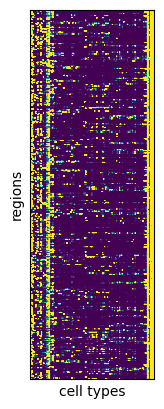

In [12]:
import matplotlib.pyplot as plt

plt.imshow(region_count_matrix.T, vmax=10)
plt.tick_params(
    axis="both",
    left=False,
    top=False,
    right=False,
    bottom=False,
    labelleft=False,
    labeltop=False,
    labelright=False,
    labelbottom=False,
)
plt.xlabel("cell types")
plt.ylabel("regions")